# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *
from tools_native import *

psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [10., 8.]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
sys.path.append('../../../PLOTS/')
from datasets import *

# Load files and edit datasets

LAM output analysis.

Simu irr et simu no-irr.

In [58]:
# lon_min=-10
# lon_max=4
# lat_min=34
# lat_max=46

In [59]:
nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/hourly_native'

## LMDZ

In [60]:
def format_lmdz_HF(filename, color, name):
    ds = xr.open_mfdataset(filename)
    ds = ds.rename({'time_counter':'time'})
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)
    ds.attrs['name'] = name
    ds.attrs['plot_color']=color

    ds['sens']=-ds['sens']
    ds['flat']=-ds['flat']

    ds['ground_level'] = ds['phis'] / 9.81
    ds['ground_level'].attrs['units'] = 'm'

    ds=add_wind_speed(ds)
    ds=add_wind_direction(ds)
    ds=add_wind_10m(ds)

    #make ovap unit g/kg
    ds['ovap'] = ds['ovap']*1000
    ds['ovap'].attrs['units'] = 'g/kg'
    #same for q2m
    ds['q2m'] = ds['q2m']*1000
    ds['q2m'].attrs['units'] = 'g/kg'
    #turn psol to hPa
    ds['psol'] = ds['psol']/100
    ds['psol'].attrs['units'] = 'hPa'
    
    return ds

In [100]:
no_irr_file = '{}/sim267_20210701_20210731_HF_histhf.nc'.format(nat_dir)
lmdz_noirr = format_lmdz_HF(no_irr_file, 'red', 'noirr')
lmdz_noirr

<xarray.Dataset>
Dimensions:               (cell: 9241, nvertex: 6, presnivs: 79, time: 744,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T00:30:00 ... 2021-...
    time_instant          (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
    time_decimal          (time) float64 0.5 1.5 2.5 3.5 ... 20.5 21.5 22.5 23.5
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/57)
    bounds_lon            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    phis                  (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    ...                    ...
    ovap                  (time, presnivs, cell) float32 dask.array<chunksize=(744, 79, 9241), meta=np.ndarray>
    ground_level          (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    wind_speed            (time, presnivs, cell) float32 dask.array<chunksize=(744, 79, 9241), meta=np.ndarray>
    wind_direction        (time, presnivs, cell) float32 dask.array<chunksize=(744, 79, 9241), meta=np.ndarray>
    wind_speed_10m        (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    wind_direction_10m    (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
Attributes:
    name:         noirr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Feb-27 10:31:33 GMT
    uuid:         7a1ed6ba-ff11-44fc-895c-391e3a6fc32e
    plot_color:   red

In [101]:
irr_file = '{}/sim268_20210701_20210731_HF_histhf.nc'.format(nat_dir)
lmdz_irr = format_lmdz_HF(irr_file, 'blue', 'irr')
lmdz_irr

<xarray.Dataset>
Dimensions:               (cell: 9241, nvertex: 6, presnivs: 79, time: 744,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T00:30:00 ... 2021-...
    time_instant          (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
    time_decimal          (time) float64 0.5 1.5 2.5 3.5 ... 20.5 21.5 22.5 23.5
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/57)
    bounds_lon            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    phis                  (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    ...                    ...
    ovap                  (time, presnivs, cell) float32 dask.array<chunksize=(744, 79, 9241), meta=np.ndarray>
    ground_level          (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    wind_speed            (time, presnivs, cell) float32 dask.array<chunksize=(744, 79, 9241), meta=np.ndarray>
    wind_direction        (time, presnivs, cell) float32 dask.array<chunksize=(744, 79, 9241), meta=np.ndarray>
    wind_speed_10m        (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    wind_direction_10m    (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Feb-27 10:28:55 GMT
    uuid:         426bef48-82eb-4639-b0ea-7c96d1010b78
    plot_color:   blue

## ORCHIDEE

In [102]:
def format_ORC_HF(filename, name, color):
    ds = xr.open_mfdataset(filename)
    ds = ds.rename({'time_counter':'time'})
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)
    ds.attrs['name'] = name
    ds.attrs['plot_color']= color
    # ds = ds.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

    ds['evapot']=ds['evapot'] * 3600 * 24
    ds['evapot'].attrs['units'] = 'mm/d'

    return ds

In [103]:
orcnoirr_file = '{}/sim267_20210701_20210731_HF_sechiba_out_2.nc'.format(nat_dir)
orc_noirr = format_ORC_HF(orcnoirr_file, 'red', 'noirr')
orc_noirr

<xarray.Dataset>
Dimensions:               (cell: 9241, nvertex: 6, veget: 15, time: 744,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
  * veget                 (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T00:30:00 ... 2021-...
    time_decimal          (time) float64 0.5 1.5 2.5 3.5 ... 20.5 21.5 22.5 23.5
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/26)
    bounds_lon            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    Areas                 (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    Contfrac              (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    ...                    ...
    tair                  (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    qair                  (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    humrel                (time, veget, cell) float32 dask.array<chunksize=(744, 15, 9241), meta=np.ndarray>
    root_deficit          (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    netirrig              (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    irrigation            (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
Attributes:
    name:         red
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Feb-27 10:31:32 GMT
    uuid:         1810e4d6-1b5f-47bd-8204-5688cbb4dabb
    plot_color:   noirr

In [104]:
orcirr_file =  '{}/sim268_20210701_20210731_HF_sechiba_out_2.nc'.format(nat_dir)
orc_irr = format_ORC_HF(orcirr_file, 'blue', 'irr')
orc_irr

<xarray.Dataset>
Dimensions:               (cell: 9241, nvertex: 6, veget: 15, time: 744,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    lon                   (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
  * veget                 (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T00:30:00 ... 2021-...
    time_decimal          (time) float64 0.5 1.5 2.5 3.5 ... 20.5 21.5 22.5 23.5
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/26)
    bounds_lon            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    bounds_lat            (cell, nvertex) float32 dask.array<chunksize=(9241, 6), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(744, 2), meta=np.ndarray>
    Areas                 (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    Contfrac              (cell) float32 dask.array<chunksize=(9241,), meta=np.ndarray>
    ...                    ...
    tair                  (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    qair                  (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    humrel                (time, veget, cell) float32 dask.array<chunksize=(744, 15, 9241), meta=np.ndarray>
    root_deficit          (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    netirrig              (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
    irrigation            (time, cell) float32 dask.array<chunksize=(744, 9241), meta=np.ndarray>
Attributes:
    name:         blue
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Feb-27 10:28:54 GMT
    uuid:         d06f6f71-98f2-4163-8bdd-85f80d561d37
    plot_color:   irr

## Selecting subdatasets

### LIAISE sites

In [105]:
#on grid cell
#highirr
Cendrosa_lon=0.755
Cendrosa_lat=41.63
#lowirr
ElsPlans_lon=0.996
ElsPlans_lat=41.51

# alt for these grid cells : (307.6005859375, 456.8945007324219)

In [106]:
#actual data from LIAISE db
Cendrosa_Latitude=41.69336
Cendrosa_Longitude=0.928538
Cenrosa_Altitude= 240

ElsPlans_Latitude = 41.590111
ElsPlans_Longitude = 1.029363
ElsPlans_Altitude = 334

In [107]:
cen_lmdz_noirr = sel_closest(lmdz_noirr, Cendrosa_lon, Cendrosa_lat)
cen_lmdz_noirr.attrs['name']='La Cendrosa no_irr'
cen_lmdz_irr = sel_closest(lmdz_irr, lon=Cendrosa_lon,lat=Cendrosa_lat)
cen_lmdz_irr.attrs['name']='La Cendrosa irr'
cen_orc_noirr = sel_closest(orc_noirr, lon=Cendrosa_lon,lat=Cendrosa_lat)
cen_orc_noirr.attrs['name']='La Cendrosa no_irr'
cen_orc_irr = sel_closest(orc_irr, lon=Cendrosa_lon,lat=Cendrosa_lat)
cen_orc_irr.attrs['name']='La Cendrosa irr'

In [108]:
els_lmdz_noirr = sel_closest(lmdz_noirr, lon=ElsPlans_lon,lat=ElsPlans_lat)
els_lmdz_irr   = sel_closest(lmdz_irr, lon=ElsPlans_lon,lat=ElsPlans_lat)
els_orc_noirr  = sel_closest(orc_noirr, lon=ElsPlans_lon,lat=ElsPlans_lat)
els_orc_irr    = sel_closest(orc_irr, lon=ElsPlans_lon,lat=ElsPlans_lat)
els_lmdz_irr.attrs['name']='Els Plans irr'
els_orc_noirr.attrs['name']='Els Plans no_irr'
els_lmdz_noirr.attrs['name']='Els Plans no_irr'
els_orc_irr.attrs['name']='Els Plans irr'

In [109]:
cendrosa_gl= cen_lmdz_noirr['ground_level'].mean(dim='time').values.item()
elsplans_gl= els_lmdz_noirr['ground_level'].mean(dim='time').values.item()
cendrosa_gl,  elsplans_gl

(307.6005859375, 456.8945007324219)

In [ ]:
#add attr linestyle -- to els_ datasets
els_lmdz_noirr.attrs['linestyle']='--'
els_lmdz_irr.attrs['linestyle']='--'
els_orc_noirr.attrs['linestyle']='--'
els_orc_irr.attrs['linestyle']='--'
#add attr linestyle - to cen_ datasets
cen_lmdz_noirr.attrs['linestyle']='-'
cen_lmdz_irr.attrs['linestyle']='-'
cen_orc_noirr.attrs['linestyle']='-'
cen_orc_irr.attrs['linestyle']='-'

### Golden days

In [114]:
start_time = '2021-07-21T00:30:00.000000000'
day1_end_time = '2021-07-21T23:30:00.000000000'
day2_start_time = '2021-07-22T00:30:00.000000000'
end_time='2021-07-22T23:30:00.000000000'

In [115]:
gold_cen_lmdz_noirr = filter_xarray_by_timestamps(cen_lmdz_noirr, start_time, end_time)
gold_cen_lmdz_irr = filter_xarray_by_timestamps(cen_lmdz_irr, start_time, end_time)
gold_cen_orc_noirr = filter_xarray_by_timestamps(cen_orc_noirr, start_time, end_time)
gold_cen_orc_irr = filter_xarray_by_timestamps(cen_orc_irr, start_time, end_time)

gold_els_lmdz_noirr = filter_xarray_by_timestamps(els_lmdz_noirr, start_time, end_time)
gold_els_lmdz_irr = filter_xarray_by_timestamps(els_lmdz_irr, start_time, end_time)
gold_els_orc_noirr = filter_xarray_by_timestamps(els_orc_noirr, start_time, end_time)
gold_els_orc_irr = filter_xarray_by_timestamps(els_orc_irr, start_time, end_time)

In [116]:
#day1
day1_cen_lmdz_noirr = filter_xarray_by_timestamps(cen_lmdz_noirr, start_time, day1_end_time)
day1_cen_lmdz_irr = filter_xarray_by_timestamps(cen_lmdz_irr, start_time, day1_end_time)
day1_cen_orc_noirr = filter_xarray_by_timestamps(cen_orc_noirr, start_time, day1_end_time)
day1_cen_orc_irr = filter_xarray_by_timestamps(cen_orc_irr, start_time, day1_end_time)

day1_els_lmdz_noirr = filter_xarray_by_timestamps(els_lmdz_noirr, start_time, day1_end_time)
day1_els_lmdz_irr = filter_xarray_by_timestamps(els_lmdz_irr, start_time, day1_end_time)
day1_els_orc_noirr = filter_xarray_by_timestamps(els_orc_noirr, start_time, day1_end_time)
day1_els_orc_irr = filter_xarray_by_timestamps(els_orc_irr, start_time, day1_end_time)

#day2
day2_cen_lmdz_noirr = filter_xarray_by_timestamps(cen_lmdz_noirr, day2_start_time, end_time)
day2_cen_lmdz_irr = filter_xarray_by_timestamps(cen_lmdz_irr, day2_start_time, end_time)
day2_cen_orc_noirr = filter_xarray_by_timestamps(cen_orc_noirr, day2_start_time, end_time)
day2_cen_orc_irr = filter_xarray_by_timestamps(cen_orc_irr, day2_start_time, end_time)

day2_els_lmdz_noirr = filter_xarray_by_timestamps(els_lmdz_noirr, day2_start_time, end_time)
day2_els_lmdz_irr = filter_xarray_by_timestamps(els_lmdz_irr, day2_start_time, end_time)
day2_els_orc_noirr = filter_xarray_by_timestamps(els_orc_noirr, day2_start_time, end_time)
day2_els_orc_irr = filter_xarray_by_timestamps(els_orc_irr, day2_start_time, end_time)

## Obs

### RS

In [123]:
cendrosa_dir='../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_RS_L2'
cendrosa_files_d1=[
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-0401_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-0501_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-0601_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-0702_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-0806_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-0900_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1011_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1103_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1204_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1302_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1358_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1501_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1557_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210721-1700_V2.nc"
]
cen_d1_times=[4,5,6,7,8,9,10,11,12,13,14,15,16,17]
cendrosa_files_d2=[    
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-0400_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-0500_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-0559_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-0659_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-0800_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-0900_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1001_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1100_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1200_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1300_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1359_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1501_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1600_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1746_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-1906_V2.nc",
    "LIAISE_LA-CENDROSA_CNRM_RS-ascent_L2_20210722-2117_V2.nc"
]
cen_d2_times=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,21]

In [124]:
els_dir='../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_radiosondes_L1'
els_files_d1=[
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-040008_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-050014_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-060007_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-070006_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-080011_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-090008_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-100006_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-110120_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-120247_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-130018_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-140032_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-150048_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-160010_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-170010_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-190058_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210721-210029_V1.0.txt"
]
els_d1_times=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,21]
els_files_d2=[
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-040029_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-050013_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-060005_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-070034_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-080006_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-090001_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-100009_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-110011_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-120040_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-130007_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-140158_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-150035_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-160021_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-170013_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-190010_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-200336_V1.0.txt",
    "LIAISE_ELS-PLANS_UKMO_RADIOSONDEPROFILE_L1-20210722-210010_V1.0.txt"
]
els_d2_times=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21]

In [125]:
#create dict for Cendrosa on d1
# Initialize the dictionary to store datasets
cen_RS_d1 = {}
# Loop over the files
for i, file in enumerate(cendrosa_files_d1):
    # Read the data
    file_path=f'{cendrosa_dir}/{file}'
    ds=format_Cendrosa_RS(file_path)
    # Add the time
    ds.attrs['rs_time'] = cen_d1_times[i]
    # Add the dataset to the dictionary with the corresponding time as the key
    cen_RS_d1[cen_d1_times[i]] = ds

#$create dict for Cendrosa on d2
# Initialize the dictionary to store datasets
cen_RS_d2 = {}
# Loop over the files
for i, file in enumerate(cendrosa_files_d2):
    # Read the data
    file_path=f'{cendrosa_dir}/{file}'
    ds=format_Cendrosa_RS(file_path)
    # Add the time
    ds.attrs['rs_time'] = cen_d2_times[i]
    # Add the dataset to the dictionary with the corresponding time as the key
    cen_RS_d2[cen_d2_times[i]] = ds

cen_RS_d2[13]

<xarray.Dataset>
Dimensions:         (time: 315, level: 2)
Coordinates:
  * time            (time) datetime64[ns] 2021-07-22T13:00:38 ... 2021-07-22T...
Dimensions without coordinates: level
Data variables: (12/14)
    time_bnds       (time, level) datetime64[ns] dask.array<chunksize=(315, 2), meta=np.ndarray>
    ascentRate      (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    pressure        (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    altitude        (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    temperature     (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    humidity        (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    ...              ...
    wind_speed      (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    wind_direction  (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    latitude        (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    longitude       (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    theta           (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
    ovap            (time) float32 dask.array<chunksize=(315,), meta=np.ndarray>
Attributes: (12/28)
    creator_name:              /DESR/CNRM/GMEI/4M
    creator_email:             axel.roy@meteo.fr
    institution:               CNRM, Université de Toulouse, Météo-France, CN...
    acqid:                     Cr210092-Cr210092
    title:                     Sounding data during the LIAISE campaign (leve...
    instrument_id:             Vaisala-RS
    ...                        ...
    geospatial_lon_max:        0.928538
    geospatial_lat_min:        41.693406
    geospatial_lat_max:        41.693406
    name:                      Cendrosa_RS
    plot_color:                black
    rs_time:                   13

In [126]:
#create dict for ELS on d1
# Initialize the dictionary to store datasets
els_RS_d1 = {}
# Iterate over the files and populate the dictionary
for i, filename in enumerate(els_files_d1):
    filepath = f'{els_dir}/{filename}'
    ds = format_ElsPlans_RS(filepath)
    # Add rs_time attribute
    ds.attrs['rs_time'] = els_d1_times[i]
    # Add the dataset to the dictionary with the corresponding time as the key
    els_RS_d1[els_d1_times[i]] = ds
    
#create dict for ELS on d2
# Initialize the dictionary to store datasets
els_RS_d2 = {}
# Iterate over the files and populate the dictionary
for i, filename in enumerate(els_files_d2):
    filepath = f'{els_dir}/{filename}'
    ds = format_ElsPlans_RS(filepath)
    # Add rs_time attribute
    ds.attrs['rs_time'] = els_d2_times[i]
    # Add the dataset to the dictionary with the corresponding time as the key
    els_RS_d2[els_d2_times[i]] = ds

els_RS_d2[4]

<xarray.Dataset>
Dimensions:         (time: 2512)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 6 ... 2507 2508 2509 2510 2511 2512
Data variables: (12/14)
    altitude        (time) int64 0 0 0 0 0 0 0 ... 6906 6909 6911 6914 6917 6920
    pressure        (time) float64 961.7 961.7 961.7 961.7 ... 411.6 411.4 411.2
    temperature     (time) float64 299.3 299.3 299.3 299.3 ... 255.7 255.6 255.6
    humidity        (time) float64 40.8 40.48 40.26 40.04 ... 10.19 10.26 10.36
    dewPoint        (time) float64 11.82 11.71 11.63 ... -41.68 -41.64 -41.57
    mixingRatio     (time) float64 9.1 9.03 8.98 8.93 ... 0.24 0.24 0.24 0.24
    ...              ...
    Latitude        (time) float64 41.59 41.59 41.59 41.59 ... 41.6 41.6 41.6
    Longitude       (time) float64 1.031 1.031 1.031 1.031 ... 1.213 1.213 1.213
    Range           (time) int64 0 31 41 44 42 ... 15164 15176 15188 15200 15212
    Azimuth         (time) int64 0 350 348 346 344 343 341 ... 86 86 86 86 86 86
    theta           (time) float64 302.7 302.7 302.7 302.7 ... 329.6 329.6 329.6
    ovap            (time) float64 9.018 8.949 8.9 ... 0.2399 0.2399 0.2399
Attributes:
    Balloon release time                     2021-07-22 04:00:29 UTC:  
    Station name                             LIAISE_ELS_PLANS:         
    Station latitude                         41.59 N:                  
    Station longitude                        01.03 E:                  
    Station height above sea level           335 m:                    
    Sonde type                               RS92-SGP:                 
    Sonde serial number                      L4133832:                 
    name:                                                              ElsPla...
    plot_color:                                                        black
    rs_time:                                                           4

### Masts measurements

In [131]:
def format_Cendrosa_MTO(filename):
    cen_mto = xr.open_dataset(filename)
    #add name and plot color
    cen_mto.attrs['name'] = 'Cendrosa_MTO'
    cen_mto.attrs['plot_color'] = 'black'
    cen_mto.attrs['linestyle']='-'

    rename_dict = {
        #lmdz vars
        'ta_2':'t2m',
        'shf_1':'sens',
        'lhf_1':'flat',
        'hur_2':'rh2m',
        'hus_2':'q2m',
        'ws_2':'wind_speed_10m',
        'wd_2':'wind_direction_10m',
        'pa':'psol',
        'swup':'SWupSFC',
        'lwup':'LWupSFC',
        #orc vars
        'soil_temp_1':'temp_sol',
        'soil_heat_flux':'Qg',
    }
    cen_mto = cen_mto.rename(rename_dict)

    #change temperatures to K
    cen_mto['t2m'] = cen_mto['t2m'] + 273.15
    cen_mto['t2m'].attrs['units'] = 'K'
    #change sign of Qg
    cen_mto['Qg'] = -cen_mto['Qg']
    #make netrad fluxes
    cen_mto['lwnet'] = cen_mto['lwd'] - cen_mto['LWupSFC']
    cen_mto['lwnet'].attrs['units'] = 'W/m2'
    cen_mto['swnet'] = cen_mto['swd'] - cen_mto['SWupSFC']
    cen_mto['swnet'].attrs['units'] = 'W/m2'

    return(cen_mto)

In [132]:
filename = '../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2_2021-07-21_V3.nc'
day1_cen_mto = format_Cendrosa_MTO(filename)

filename = '../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2_2021-07-22_V3.nc'
day2_cen_mto = format_Cendrosa_MTO(filename)

#concatenate both ds in gold_cen_mto
gold_cen_mto = xr.concat([day1_cen_mto,day2_cen_mto],dim='time')
gold_cen_mto

<xarray.Dataset>
Dimensions:                (time: 96, level: 2)
Coordinates:
  * time                   (time) datetime64[ns] 2021-07-21T00:30:00 ... 2021...
Dimensions without coordinates: level
Data variables: (12/111)
    time_bnds              (time, level) datetime64[ns] 2021-07-21 ... 2021-0...
    Qg                     (time) float32 25.65 26.97 26.62 ... 23.34 26.26
    rain_cumul             (time) float32 0.2 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temp_sol               (time) float32 27.25 27.02 26.73 ... 27.48 27.19 26.9
    soil_temp_2            (time) float32 26.43 26.16 25.89 ... 26.87 26.58 26.3
    soil_temp_3            (time) float32 26.13 26.1 26.02 ... 26.41 26.35 26.3
    ...                     ...
    w_u_cov_3              (time) float32 -0.2366 0.1068 ... 0.02434 -0.06005
    w_v_cov_1              (time) float32 0.0123 0.01675 ... 0.03947 0.00467
    w_v_cov_2              (time) float32 nan 0.004807 ... 0.03015 0.04652
    w_v_cov_3              (time) float32 -0.1205 0.1424 ... 0.05792 0.03852
    lwnet                  (time) float32 -9.04 -43.61 -54.86 ... -63.06 -53.35
    swnet                  (time) float32 -9.347 -4.472 -3.237 ... -3.78 -3.671
Attributes: (12/36)
    creator_name:              William Maurel
    creator_email:             contact.tramm-cnrm@meteo.fr
    acqid:                     Ce210202
    processing_level:          L2
    nom_aeris:                 LA-CENDROSA
    doi:                       https//doi.org/10.25326/320
    ...                        ...
    geospatial_lon_max:        0.92841
    geospatial_lat_min:        41.69336
    geospatial_lat_max:        41.69336
    name:                      Cendrosa_MTO
    plot_color:                black
    linestyle:                 -

In [133]:
def format_ElsPlans_MTO(ds, start_day):
    #add name and plot color
    ds.attrs['name'] = 'ElsPlans_MTO'
    ds.attrs['plot_color'] = 'black'
    ds.attrs['linestyle']='--'

    rename_dict = {
        'HOUR_time':'time',
        #lmdz vars
        'PRES_subsoil':'psol',
        'TEMP_2m':'t2m',
        'RHUM_2mB':'rh2m',
        'UTOT_10m':'wind_speed_10m',
        'DIR_10m':'wind_direction_10m',
        'SWUP_rad':'SWupSFC',
        'LWUP_rad':'LWupSFC',
        #orc vars
        'SFLXA_subsoil':'Qg',
        'ST01_subsoil':'temp_sol',
    }
    ds = ds.rename(rename_dict)

    #convert time to hour:mn:s
    ds['time'] = pd.to_datetime(start_day) + pd.to_timedelta(ds['time'], unit='h')

    #remove all values of 1e11
    ds = ds.where(ds != 1e11)
    # change temperatures to K
    ds['t2m'] = ds['t2m'] + 273.15
    ds['t2m'].attrs['units'] = 'K'
    #get turbulent fluxes
    # Latent heat of vaporization of water in J/kg
    lambda_v = 2.5e6
    ds['flat'] = ds['WQ_2m'] * lambda_v
    ds['flat'].attrs['units'] = 'W/m2'
    # air density in kg/m3 and specific heat capacity of air in J/kg/K
    rho=1.225
    cp=1004.67
    ds['sens'] = ds['WT_2m'] * rho * cp
    ds['sens'].attrs['units'] = 'W/m2'
    # make net rad fluxes
    ds['lwnet'] = ds['LWDN_rad'] - ds['LWupSFC']
    ds['lwnet'].attrs['units'] = 'W/m2'
    ds['swnet'] = ds['SWDN_rad'] - ds['SWupSFC']
    ds['swnet'].attrs['units'] = 'W/m2'
    #change sign of Qg
    ds['Qg'] = -ds['Qg']

    return(ds)

In [134]:
filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210721_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
day1_els_mto = format_ElsPlans_MTO(ds, start_day='2021-07-21')
# day1_els_mto

filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210722_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
day2_els_mto = format_ElsPlans_MTO(ds, start_day='2021-07-22')
# day2_els_mto

#concatenate
gold_els_mto = xr.concat([day1_els_mto,day2_els_mto],dim='time')
gold_els_mto

<xarray.Dataset>
Dimensions:             (time: 96)
Coordinates:
  * time                (time) datetime64[ns] 2021-07-21T00:15:00 ... 2021-07...
Data variables: (12/151)
    UTOT_50m            (time) float64 8.206 2.178 4.312 ... 5.364 6.21 7.205
    USCL_50m            (time) float64 8.681 4.526 4.637 ... 5.395 6.224 7.214
    UMAX_50m            (time) float64 11.8 9.179 7.132 ... 7.715 7.9 8.588
    DIR_50m             (time) float64 207.6 151.8 37.13 ... 129.0 126.6 126.5
    TEMP_50m            (time) float64 24.17 25.51 23.61 ... 28.06 27.48 27.52
    UU_50m              (time) float64 2.116 6.984 0.6861 ... 0.2856 0.1846
    ...                  ...
    RAIN_subsoil        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VIS_vis             (time) float64 31.32 31.91 32.0 ... 30.74 31.26 29.23
    flat                (time) float64 62.96 15.19 19.67 ... 1.755 2.095 1.84
    sens                (time) float64 -46.24 -20.27 -26.24 ... -34.13 -30.81
    lwnet               (time) float64 -21.21 -39.72 -56.98 ... -80.86 -81.85
    swnet               (time) float64 -0.7408 0.1122 0.1635 ... 0.0297 0.4969
Attributes:
    name:        ElsPlans_MTO
    plot_color:  black
    linestyle:   --

# Maps

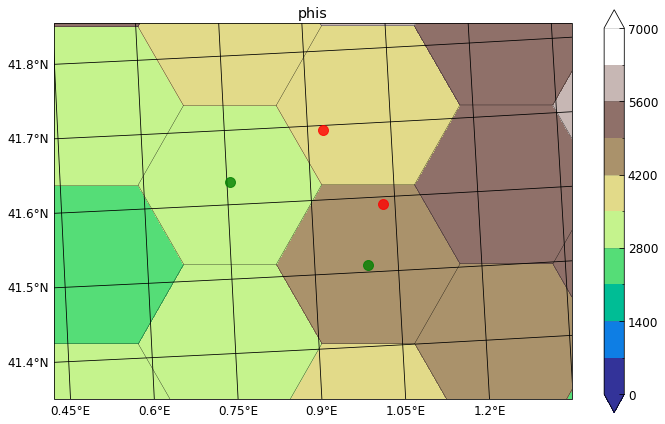

In [135]:
file=no_irr_file
var='phis'

lat_min=41.35
lat_max=41.82
lon_min=0.45
lon_max=1.35

vmin=00.0
vmax=7000

plot_ICO_from_netcdf(file, var, 
                     cmap=myterrain,
                     lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max,
                     vmin=vmin, vmax=vmax, 
                    #  title='Irrigation'
    )

ax = plt.gca()
ax.plot(Cendrosa_lon, Cendrosa_lat, 'go', markersize=10, transform=ccrs.Geodetic())
ax.plot(ElsPlans_lon, ElsPlans_lat, 'go', markersize=10, transform=ccrs.Geodetic())
ax.plot(Cendrosa_Longitude, Cendrosa_Latitude, 'ro', markersize=10, transform=ccrs.Geodetic())
ax.plot(ElsPlans_Longitude, ElsPlans_Latitude, 'ro', markersize=10, transform=ccrs.Geodetic())

# Time series

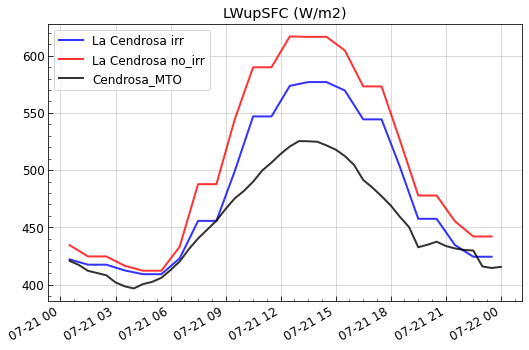

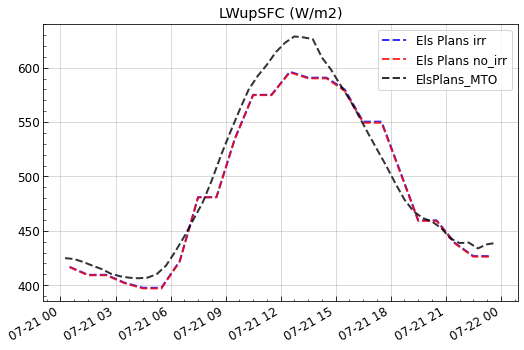

In [ ]:
var='LWupSFC'

ds1=day1_cen_lmdz_irr
ds2=day1_cen_lmdz_noirr
ds3=day1_els_lmdz_irr
ds4=day1_els_lmdz_noirr
ds5=day1_cen_mto
ds6=day1_els_mto

ds_list=[ds1, ds2, ds5]
# ds_list=[ds3, ds4, gold_els_mto]

vmin=-0
vmax=500
vmin, vmax=None, None
title='{} ({})'.format(var, ds1[var].attrs['units'])
# title=None

time_series_ave(ds_list, var, ds_colors=True, ds_linestyle=True, title=title, vmin=vmin, vmax=vmax)

ds_list=[ds3, ds4, ds6]
time_series_ave(ds_list, var, ds_colors=True, ds_linestyle=True, title=title, vmin=vmin, vmax=vmax)

# Vertical profiles

MemoryError: Unable to allocate 2.02 GiB for an array with shape (744, 79, 9241) and data type float32

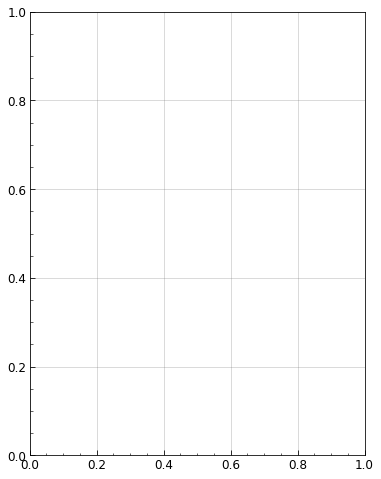

In [155]:
var='theta'
ds1=day1_els_lmdz_irr
ds2=day1_els_lmdz_noirr
ds3=day1_cen_lmdz_irr
ds4=day1_cen_lmdz_noirr

ds_list=[ds1, ds2, ds3, ds4]
# ds_list=[ds3, ds4]
ds_list=[ds1]

# obs_ds_list=[Cendrosa_RS]
obs_ds_list=None

altmax=2500

title=None

# profile_preslevs_local(ds_list, var, title=title, preslevelmax=preslevelmax)
profile_altitude_local_mean(ds_list, var, title=title, altmax=altmax,
                            obs_ds_list=obs_ds_list,
                            nbins=None,
                            substract_gl=True,
                            )